GitHub: https://github.com/bevanyeah/Assignments

Welcome to your assignment this week! 

To better understand explainable AI, in this assignment, we will look at the __LIME__ framework to explain potential black-box machine learning models in a model-agnostic way. We use a real-world dataset on Census income, also known as the __[*Adult dataset*](https://archive.ics.uci.edu/ml/datasets/Adult)__ available in the *UCI* ML Repository where we will predict if the potential income of people is more than $50K/year or not.

For this assignment, we will use: 

- [XGBoost](https://xgboost.readthedocs.io/en/latest/) (XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable.). Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees.
- [Decision Tree](https://en.wikipedia.org/wiki/Decision_tree) which is a decision support tool that uses a tree-like model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It is one way to display an algorithm that only contains conditional control statements. Decision trees are commonly used in operations research, specifically in decision analysis, to help identify a strategy most likely to reach a goal, but are also a popular tool in machine learning.




__[LIME GitHub](https://github.com/marcotcr/lime)__


**After this assignment you will be able to:** use the __LIME__ framework to explain potential black-box machine learning models in a model-agnostic way.


Let's get started! Run the following cell to install all the packages you will need.


In [162]:
# !pip install numpy
# !pip install matplotlib
# !pip install lime
# !pip install shap
# !pip install sklearn
# !pip install xgboost
# !pip install graphviz
# !pip install pydot
# !pip install pydotplus
# !pip install seaborn


Run the following cell to load the packages you will need.

In [163]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

import seaborn as sns
import lime
from lime.lime_tabular import LimeTabularExplainer
import shap
import itertools

##
from utils import *
##

from sklearn.model_selection import train_test_split
from collections import Counter
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import graphviz
from io import StringIO
from sklearn import datasets,tree
import pydot
import pydotplus
from sklearn.tree import export_graphviz
from IPython.display import Image


import warnings
warnings.filterwarnings('ignore')
#plt.style.use('fivethirtyeight')
%matplotlib inline

shap.initjs()

Next, let's load the census dataset. Run the following cell to load the features `X` and the labels `y`. 

In [164]:
X_raw, y = shap.datasets.adult(display=True)

X_raw = X_raw.drop(columns=['Capital Gain']) # These two features are intentionally removed.
X_raw = X_raw.drop(columns=['Capital Loss']) # These two features are intentionally removed.

labels = np.array([int(label) for label in y])

print('The shape of X_raw is: ',X_raw.shape)
print('The shape of y is: ',labels.shape)

The shape of X_raw is:  (32561, 10)
The shape of y is:  (32561,)


You've loaded:

- `X_raw`: a DataFrame containing 32,561 instances with 12 features.
- `y`: the list of binary labels for the 32,561 examples. If salary of instance $i$ is more than \\$50K: $y^{(i)} = 1$ otherwise: $y^{(i)} = 0$.


# Understanding the Census Income Dataset

Let's now take a look at our dataset attributes and understand their meaning and significance.


|Num| Attribute Name | Type | Description |
|----|----------------------------------------------------------|------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|1| Age | Continuous | Represents age of the person <br>(Private, Self-emp-not-inc, Self-emp-inc, Federal-gov,  <br>Local-gov, State-gov, Without-pay, Never-worked)|
|2| Workclass | Categorical | Represents the workclass of the person. <br> (Private, Self-emp-not-inc, Self-emp-inc, Federal-gov,<br> Local-gov, State-gov, Without-pay, Never-worked). |
|3| Education-Num | Categorical | Numeric representation of educational qualification.<br>Ranges from 1-16.<br>(Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, <br>9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool) |
|4| Marital Status | Categorical | Represents the marital status of the person<br>(Married-civ-spouse, Divorced, Never-married, Separated, <br>Widowed, Married-spouse-absent, Married-AF-spouse) |
|5| Occupation | Categorical | Represents the type of profession job of the person<br>(Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, <br>Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, <br>Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, <br>Armed-Forces) |
|6| Relationship | Categorical | Represents the relationship status of the person<br>(Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried) |
|7| Race | Categorical | Represents the race of the person<br>(White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black) |
|8| Sex | Categorical | Represents the gender of the person<br>(Female, Male) |
|9| Capital Gain | Continuous | The total capital gain for the person |
|10| Capital Loss | Continuous | The total capital loss for the person |
|11| Hours per week | Continuous | Total hours spent working per week |
|12| Country | Categorical | The country where the person was born |
|13| Income Label  | Categorical | The class label column is the one we want to predict |     



We have a total of 12 features and our objective is to predict if the income of a person will be more than $\$50$K  (True) or less than $\$50$K (False). Hence we will be building and interpreting a classification model. 

Let's have a look at the first three instances of the dataset (you can use `X.head(3)` to see the content of the dataset):


![](images/dataset.png)


For example, the first person is 39 years old, works for the state governement, is a Male and was born in the US. By using `y[0:3]` you can get  binary values indicating whether these persons have an income higher than $\$50$K or no.

# Pre-processing
Converting the categorical columns with string values to numeric representations. Typically the XGBoost model can handle categorical data natively being a tree-based model so we don't one-hot encode the features

In [165]:
mapping = {}
cat_cols = X_raw.select_dtypes(['category']).columns
for col in cat_cols:
    mapping[col] = dict( enumerate(X_raw[col].cat.categories ) )
indices_cat_cols = [ list(X_raw.columns).index(x) for x in cat_cols ]
X = X_raw.copy()
X[cat_cols] = X_raw[cat_cols].apply(lambda x: x.cat.codes)
headers=list(X.columns)
X.head(3)

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Hours per week,Country
0,39.0,7,13.0,4,1,1,4,1,40.0,39
1,50.0,6,13.0,2,4,0,4,1,13.0,39
2,38.0,4,9.0,0,6,1,4,1,40.0,39


Let's have a look at the distribution of people with <=  $\$50$K (0) and > $\$50$K (1) income:

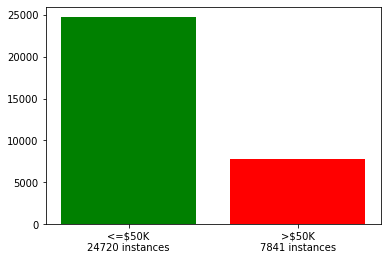

In [166]:
plt.bar([0], height=[Counter(labels)[0]], color="green")
plt.bar([1], height=[Counter(labels)[1]], color="red")
plt.xticks([0, 1], ['<=$50K\n'+str(Counter(labels)[0])+' instances',
                    '>$50K\n'+str(Counter(labels)[1])+' instances'])
plt.show()

# Split Train and Test Datasets

As in any Machine Learning, we need to partition the dataset into two subsets -- a training and testset. Please note that in practice, the dataset needs to be partitioned into three subsets, the third once being the validation set which will be used for hyperparameters tuning. However, in this assignment, we will not tune the hyperparameters.

Run the following to split the dataset accordingly:


In [167]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42, stratify=y)
print('The shape of training set is: ',X_train.shape)
print('The shape of test set is: ',X_test.shape)


The shape of training set is:  (22792, 10)
The shape of test set is:  (9769, 10)


You've created:

- `X_train`: a trainig DataFrame containing 22,792 instances used for training.
- `y_train`: the list of binary labels for the 22,792 instances of the training set.
- `X_test`: a test DataFrame containing 9,769 instances used for  testing.
- `y_test`: the list of binary labels for the 9,769 instances of the test set.

We note that since we are using a stratified splitting, the distribution of samples in the training and test set is similar to the distribution in the dataset, i.e., roughly 24% of positive examples in each subset.

## Training the classification model

Now we train and build a boosting classification model on our training data using [XGBoost](https://xgboost.readthedocs.io/en/latest/) (XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable.). Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees.

Run the following to start the training of the classifier:

In [168]:
xgc = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=42)
xgc.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

# Predictions on the test data

Now that the classifier is trained, let's make few predictions on the test set:

In [169]:
predictions = xgc.predict(X_test)
print("The values predicted for the first 20 test examples are:")
print(predictions[:20])

print("The true values are:")
print(y_test[:20])

The values predicted for the first 20 test examples are:
[1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0]
The true values are:
[1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0]


As you can see, our classier is making only 2 errors!

# Model Performance 
 Let's now evaluate the performance of our classifier on the test set. For that, we will call `sklearn.metrics.classification_report()` which returns a text report showing the main classification metrics including: Presicion, Recall, and F1-Score. The reported averages include macro average (averaging the unweighted mean per label) and weighted average (averaging the support-weighted mean per label). 




 

In [170]:
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.91      0.89      7417
           1       0.67      0.60      0.64      2352

    accuracy                           0.83      9769
   macro avg       0.78      0.76      0.76      9769
weighted avg       0.83      0.83      0.83      9769



To get more details, let's print the confusion matrix:

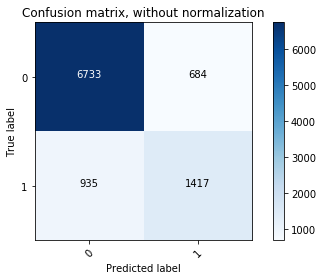

In [171]:
class_labels = list(set(labels))
cnf_matrix = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cnf_matrix, classes=class_labels,
                      title='Confusion matrix, without normalization')




***

**Task 1**: Please provide comments on the performance of the classifier.

The number of Class 0 elements is much bigger than class 1, so our accuracy measurement (83%) is likely not to be very informative.

Precision and recall is quite high for class 0 predictions (88% and 91% respectively); however, the model is let down by somewhat poor performance in predicting class 1 results.  
Both precision and recall are much lower (67% and 60%), indicating that many false negatives and false positives are present compared to true positives.

The confusion matrix confirms this, and shows that our model has limited ability to detect true class 1 results (935 false negative and only 1417 true positive), and, almost 50% (684 of 1417) of predicted class 1 were false positive.

Overall, the classifier results are not significantly great.  If a test element was predicted as being class 0, you might have some degree of confidence in the result, especially given the larger number of class 0 elements in the test data set.  However, a prediction of class 1 would not carry the same amount of confidence - and so there is little confidence in the model.

I would suggest this classifier model is not used; however, it could be useful if the classification task had minimal ethical impact (Should the person be sent a broucher vs. Should a bank loan be approved).

***

# Feature importance:

The global feature importance calcuations that come with XGBoost, enables us to view feature importances based on the following:

- **Feature Weights**: This is based on the number of times a feature appears in a tree across the ensemble of trees.
- **Gain**: This is based on the average gain of splits which use the feature.
- **Coverage**: This is based on the average coverage (number of samples affected) of splits which use the feature.

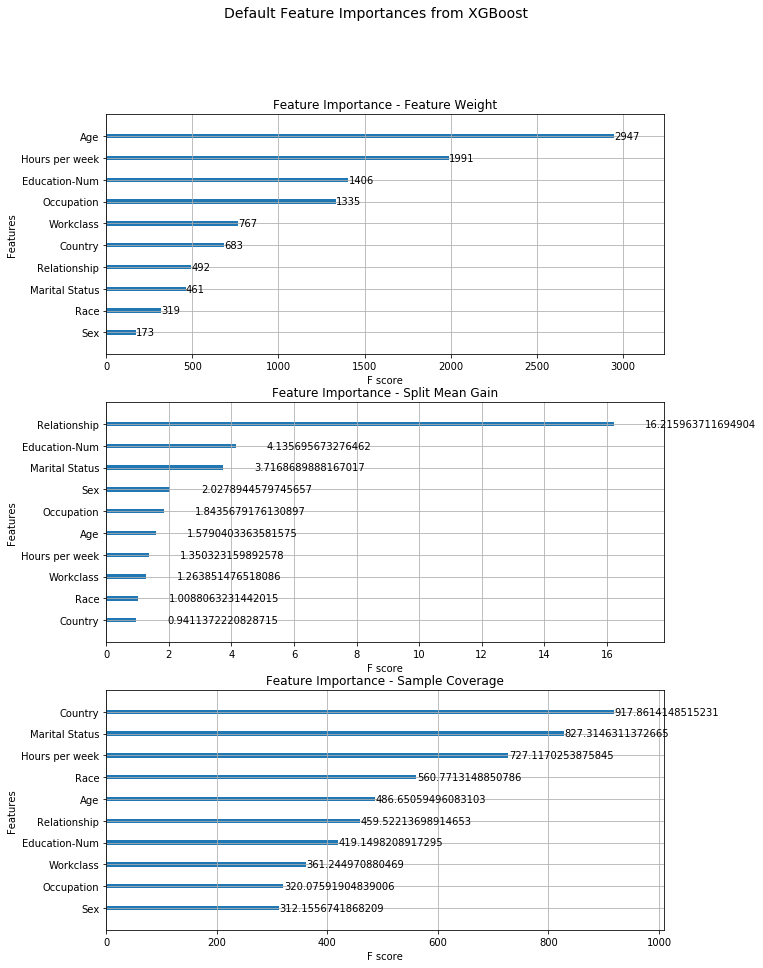

In [172]:
fig = plt.figure(figsize = (10, 15))
title = fig.suptitle("Default Feature Importances from XGBoost", fontsize=14)

ax1 = fig.add_subplot(3,1, 1)
xgb.plot_importance(xgc, importance_type='weight', ax=ax1)
t = ax1.set_title("Feature Importance - Feature Weight")

ax2 = fig.add_subplot(3,1, 2)
xgb.plot_importance(xgc, importance_type='gain', ax=ax2)
t = ax2.set_title("Feature Importance - Split Mean Gain")

ax3 = fig.add_subplot(3,1, 3)
xgb.plot_importance(xgc, importance_type='cover', ax=ax3)
t = ax3.set_title("Feature Importance - Sample Coverage")

***

**Task 2**: Please provide comments on the above global feature importance calcuations.

#### Feature Weight:

Weight favours the features that most heavily influenced the class prediction and were involved in greater number of splits; in this case, __Age__, followed by __hours worked per week__, __education__ and type of __occupation__.  The results are somewhat intuitive, however, it doesn't give the full picture.

#### Feature Gain

When looking at the Split mean Gain, we see an extremely strong performance by the __relationship__ feature.  This indicates that when using __relationship__ to split between classes, we saw a significant drop in incorrect classification.  When other features were not able to confidently classify on their own, __relationship__ can be seen as an accurate tie splitter.

#### Feature coverage

Coverage shows the amount of times the feature is used to split data, weighted by the number of training elements passing through the split.  This indicates that these features have values that might clearly belong to one class or another, and are heavily relied upon in the classifier.  Leaders in metric are __Country__, __Marital status__ and __Hours per week__.



***

# Model Interpretation Methods


![](images/Figure5-452aaf48771d7e201175954c1de6eed1.png)


# LIME:

Lime is able to explain any black box classifier, with two or more classes. All we require is that the classifier implements a function that takes in raw text or a numpy array and outputs a probability for each class. LIME tries to fit a global surrogate model, LIME focuses on fitting local surrogate models to explain why single predictions were made.

Since XGBoost has some issues with feature name ordering when building models with dataframes (we also needed feature names in the previous `plot_importance()` calls), we will build our same model with numpy arrays to make LIME work. Remember the model being built is the same ensemble model which we treat as our black box machine learning model.

Note the difference with the previous `fit` call:

<center> <b>xgc_np.fit(X_train, y_train)</b> vs. <b>xgc_np.fit(X_train.values, y_train)</b></center>

In [173]:
xgc_np = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=42)
mymodel = xgc_np.fit(X_train.values, y_train)

__`LimeTabularExplainer`__ class helps in explaining predictions on tabular (i.e. matrix) data. For numerical features, it perturbs them by sampling from a Normal(0,1) and doing the inverse operation of mean-centering and scaling, according to the means and stds in the training data. For categorical features, it perturbs by sampling according to the training distribution, and making a binary feature that is 1 when the value is the same as the instance being explained. 


__`explain_instance()`__ function generates explanations for a prediction. First, we generate neighborhood data by randomly perturbing features from the instance. We then learn locally weighted linear (surrogate) models on this neighborhood data to explain each of the classes in an interpretable way.


In [174]:
headers=list(X.columns)
explainer = LimeTabularExplainer(X_train.values, feature_names=headers, discretize_continuous=True,
                                 categorical_features=indices_cat_cols,
                                 class_names=['<= $50K', '> $50K'],verbose=True)

## When a person's income <= $50K

Lime shows which features were the most influential in the model taking the correct decision of predicting the person's income as below $50K. The below explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the actual model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in green.

***

**Task 3**: Please find a person for which the income is <= $\$50$K and the prediction is correct.

***

In [175]:
# Change only the value of to select that person:
i = 9
###########

exp1 = explainer.explain_instance(X_test.iloc[i].values, xgc_np.predict_proba, 
                                  distance_metric='euclidean', 
                                  num_features=len(X_test.iloc[i].values))
proba1 = xgc_np.predict_proba(X_test.values)[i]

print("********************")
print('Test id: ' , i)
print('Probability(',exp1.class_names[0],") =", exp1.predict_proba[0])
print('Probability(',exp1.class_names[1],") =", exp1.predict_proba[1])
print('Predicted Label:', predictions[i])
print('True class: ' , y_test[i])
print("********************")


Intercept 0.15652383789584448
Prediction_local [0.15374512]
Right: 0.030533882
********************
Test id:  9
Probability( <= $50K ) = 0.9694661
Probability( > $50K ) = 0.030533882
Predicted Label: 0
True class:  0
********************


The classifier got this example right (it predicted income $<=\$50$K). Let's have a look at the explanation provided by LIME:


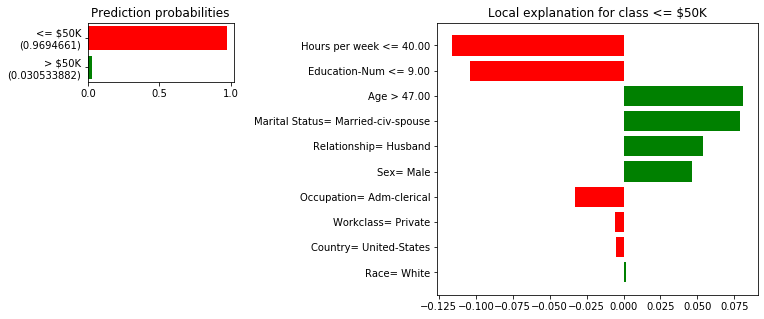

<Figure size 432x288 with 0 Axes>

In [176]:
plot_explanation(exp1, mapping)

***

**Task 4**: Please provide comments on the above explanation provided by LIME.

Person 9 is a Male person, Married and above the age of 47.  Standalone, those features may have classified him as being above $50k.

However, he has lower education (<=9) and works less than 40 hours per week. We know that from previous calculations above, they are significant features, and along with other features bring the likelihood of Person 5 to be under $50k with high degree of confidence (probability is 96.9%).
***

***
**Task 5**: Please change the value of one or two features the change the prediction of the classifier:



In [177]:
instanceModified1 = X_test.iloc[i]
instanceModified1['Hours per week'] = 60
instanceModified1['Education-Num'] = 13
print(instanceModified1)

Age               65.0
Workclass          4.0
Education-Num     13.0
Marital Status     2.0
Occupation         1.0
Relationship       0.0
Race               4.0
Sex                1.0
Hours per week    60.0
Country           39.0
Name: 11543, dtype: float32


Intercept -0.03464226112424562
Prediction_local [0.44710448]
Right: 0.90208507


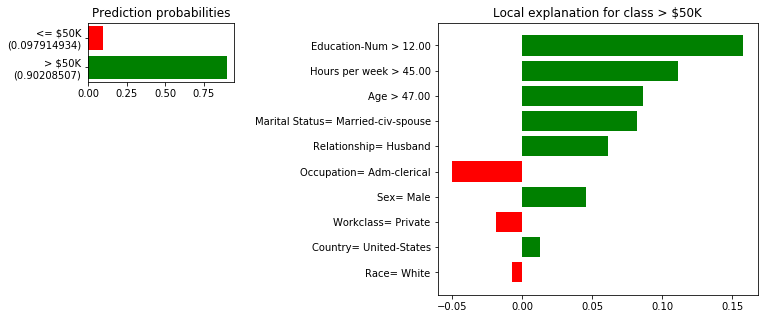

<Figure size 432x288 with 0 Axes>

In [178]:
expM1 = explainer.explain_instance(instanceModified1.values, xgc_np.predict_proba, 
                                   distance_metric='euclidean', 
                                  num_features=len(instanceModified1.values))
plot_explanation(expM1, mapping)

***
**Task 6**:  How did you choose these features for which you have changed the value? How did you chose these values?

The two most significant features in the classification of person 9 as under $50k were Hours per week and education level.  Intuition suggests that the more hours you work, and more educated you are, the more money you'll make.  So, we set the hours per week to 50, which is high yet reasonable for a busy well-paying job, and education was set at 13, which puts person 9 among the highest educated groups.

After changing these values, most feature values now contribute to person 9 as being in the above 50k salary range.



## When a person's income > $50K


Lime shows which features were the most influential in the model taking the correct decision of predicting the person's income as higher $\$50$K. The below explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the actual model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in green.

***

**Task 7**: Please find a person for which the income is > $\$50$K and the prediction is correct.

***

In [179]:
# Change only the value of to select that person:
j = 500
###########

exp2 = explainer.explain_instance(X_test.iloc[j].values, xgc_np.predict_proba, 
                                  distance_metric='euclidean', 
                                  num_features=len(X_test.iloc[j].values))
proba2 = xgc_np.predict_proba(X_test.values)[j]

print("********************")
print('Test id: ' , j)
print('Probability(',exp2.class_names[0],") =", exp2.predict_proba[0])
print('Probability(',exp2.class_names[1],") =", exp2.predict_proba[1])
print('Predicted Label:', predictions[j])
print('True class: ' , y_test[j])
print("********************")


Intercept 0.051841959260208445
Prediction_local [0.40997934]
Right: 0.7622171
********************
Test id:  500
Probability( <= $50K ) = 0.2377829
Probability( > $50K ) = 0.7622171
Predicted Label: 1
True class:  1
********************


The classifier got this example right (it predicted income $>\$50$K). Let's have a look at the explanation provided by LIME:


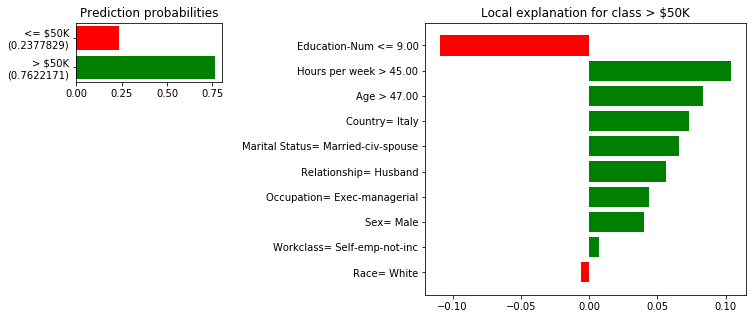

<Figure size 432x288 with 0 Axes>

In [180]:
plot_explanation(exp2, mapping)

***

**Task 8**: Please provide comments on the above explanation provided by LIME.

Person 500 has many features indicating that they get paid over $50k, except for education and race.  Education is a highly relavent feature, and likely attributes to most of the 23\% probability that person 500 belongs in the lower salary class.  

Even with a large number of relevant features, they do not provide absolute certainy with our classification, with only a 76\% probability that the chosen class was actually correct.
***

***
**Task 9**: Please change the value of one or two features the change the prediction of the classifier:



In [181]:
instanceModified2 = X_test.iloc[j]
#instanceModified2['Country'] = 3
instanceModified2['Age'] = 19
print(instanceModified2)

Age               19.0
Workclass          6.0
Education-Num      2.0
Marital Status     2.0
Occupation         4.0
Relationship       0.0
Race               4.0
Sex                1.0
Hours per week    67.0
Country           22.0
Name: 19576, dtype: float32


Intercept 0.11708730923221083
Prediction_local [0.17784854]
Right: 0.35497066


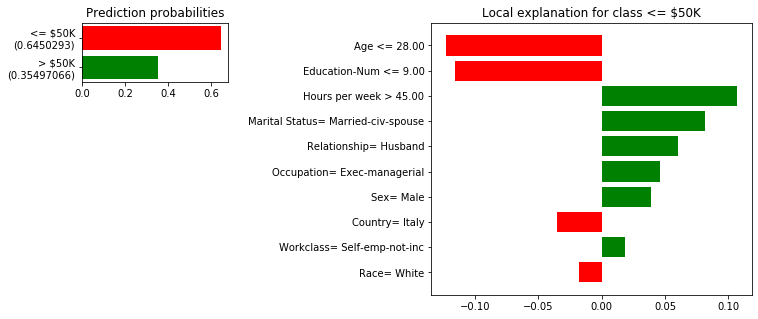

<Figure size 432x288 with 0 Axes>

In [182]:
expM2 = explainer.explain_instance(instanceModified2.values, xgc_np.predict_proba,
                                   distance_metric='euclidean', 
                                  num_features=len(instanceModified2.values))
plot_explanation(expM2, mapping)

***
**Task 10**:  How did you choose these features for which you have changed the value? How did you chose these values?

We know that from previous example, and the weights earlier in the assignment, coupled with our model being biased towards classifying as <$50k, it would probably be easy to have impact on our person 500 just by changing age.

By changing Age only to 19, a reasonable but young worker age, and keeping all other features, we see the classifier incorrectly predicting person 500 as class 0.



# When a person's income actual is different than predicted

Lime shows which features were the most influential in the model taking the incorrect decision of predicting the person's income. The below explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the actual model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in green.

***

**Task 11**: Please find a person for which the the prediction is **incorrect**.

***

In [183]:
# Change only the value of to select that person:
k = 26
###########

exp3 = explainer.explain_instance(X_test.iloc[k].values, xgc_np.predict_proba, 
                                  distance_metric='euclidean', 
                                  num_features=len(X_test.iloc[k].values))
proba3 = xgc_np.predict_proba(X_test.values)[k]

print("********************")
print('Test id: ' , k)
print('Probability(',exp3.class_names[0],") =", exp3.predict_proba[0])
print('Probability(',exp3.class_names[1],") =", exp3.predict_proba[1])
print('Predicted Label:', predictions[k])
print('True class: ' , y_test[k])
print("********************")


Intercept 0.1263028870566012
Prediction_local [0.14365]
Right: 0.32984486
********************
Test id:  26
Probability( <= $50K ) = 0.67015517
Probability( > $50K ) = 0.32984486
Predicted Label: 0
True class:  1
********************


The classifier got this example classified incorrectly. Let's have a look at the explanation provided by LIME:


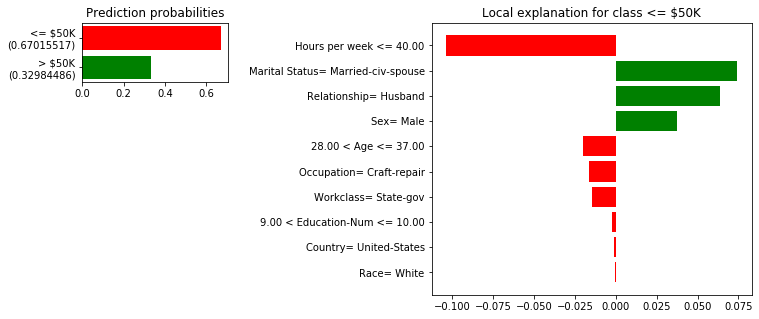

<Figure size 432x288 with 0 Axes>

In [184]:
plot_explanation(exp3, mapping)


***

**Task 12**: Please provide comments on the above explanation provided by LIME.

We know our model is biased towards predicting class 0 (<=50K).  We can see that person 26 is victim to this, mainly because they work less than 40 hours per week.
Other features such as marital status, relationship and sex are correlated to higher salaries, but are not as significant as hours worked per week.

However, even though Person 26 is incorrectly classified, the classification wasn't supremely confident, with 32\% probability of being classified as their correct class.

***

***
**Task 13**: Please change the value of one or two features the change the prediction of the classifier (to get a correct prediction):



In [185]:
instanceModified3 = X_test.iloc[k]
instanceModified3['Hours per week'] = 50
#instanceModified3['XXXX'] = ?
print(instanceModified3)

Age               31.0
Workclass          7.0
Education-Num     10.0
Marital Status     2.0
Occupation         3.0
Relationship       0.0
Race               4.0
Sex                1.0
Hours per week    50.0
Country           39.0
Name: 14628, dtype: float32


Intercept 0.018439325405903095
Prediction_local [0.27335339]
Right: 0.6034497


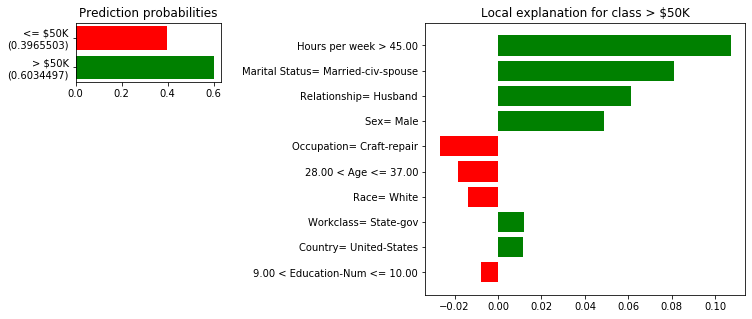

<Figure size 432x288 with 0 Axes>

In [186]:
expM3 = explainer.explain_instance(instanceModified3.values, xgc_np.predict_proba, 
                                   distance_metric='euclidean', 
                                  num_features=len(instanceModified3.values))
plot_explanation(expM3, mapping)

***
**Task 14**:  How did you choose these features for which you have changed the value? How did you chose these values?

Person 26 only really had one main significant feature that was causing the model to predict incorrectly.  We changed that value (hours per week) from a low value, to something above 45hours, which is within the highest category of 'hours per week'.  We could have selected any value above 45 and received the same results, but we picked 50 as this reasonably intuitive for a well playing busy job, or maybe indicative of overtime.

This had significant enough results that saw person 26 now correctly classified as class 1 (>$50k).





# Decision Tree

A decision tree is a decision support tool that uses a tree-like model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It is one way to display an algorithm that only contains conditional control statements.

Decision trees are commonly used in operations research, specifically in decision analysis, to help identify a strategy most likely to reach a goal, but are also a popular tool in machine learning.

Let's use the DecisionTreeClassifier provided by sklearn on our dataset:

In [187]:
tree = DecisionTreeClassifier(random_state=0, max_depth=4).fit(X_train.values, y_train)
tree.fit(X_train.values, y_train)

DecisionTreeClassifier(max_depth=4, random_state=0)

In [188]:
predictions = tree.predict(X_test)
print("The values predicted for the first 20 test examples are:")
print(predictions[:20])

print("The true values are:")
print(y_test[:20])

The values predicted for the first 20 test examples are:
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0]
The true values are:
[1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0]


In [189]:
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      7417
           1       0.75      0.40      0.52      2352

    accuracy                           0.82      9769
   macro avg       0.79      0.68      0.71      9769
weighted avg       0.81      0.82      0.80      9769



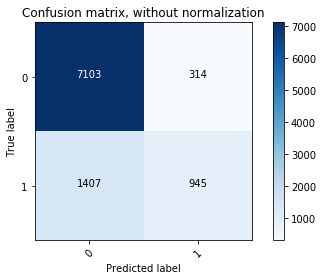

In [190]:
class_labels = list(set(labels))
cnf_matrix = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cnf_matrix, classes=class_labels,
                      title='Confusion matrix, without normalization')




***
**Task 15**:  Please provide comments on the performance of the decision Tree.

These results show similar pattern to our previous model, except worse.  We have a model that is quite biased towards classifying class 0 results.  Again, class 0 results are more numerous in our test data, so this is reflected in a somewhat high value for accuracy - which again rules accuracy as almost meaningless.

Our precision and recall values for class 0 are decent, with high number of true negative and low false positive.  So again, we see the model is confident at predicting class 0 results.
However, our model fails when predicting class 1, especially with only .40 recall.  This indicates our model is strongly biased to predicting class 0, and made less correct class 1 classifications (true positive)(945) than false negatives (1407).

This model will be difficult to rely upon.

# Visualzing the Tree

Let's generate a GraphViz representation of the decision tree:



In [191]:
dot_data = StringIO()
export_graphviz(tree, out_file=dot_data, feature_names=headers, 
                filled=True, rounded=True, impurity= False, class_names=['<=$50K','>$50K'])


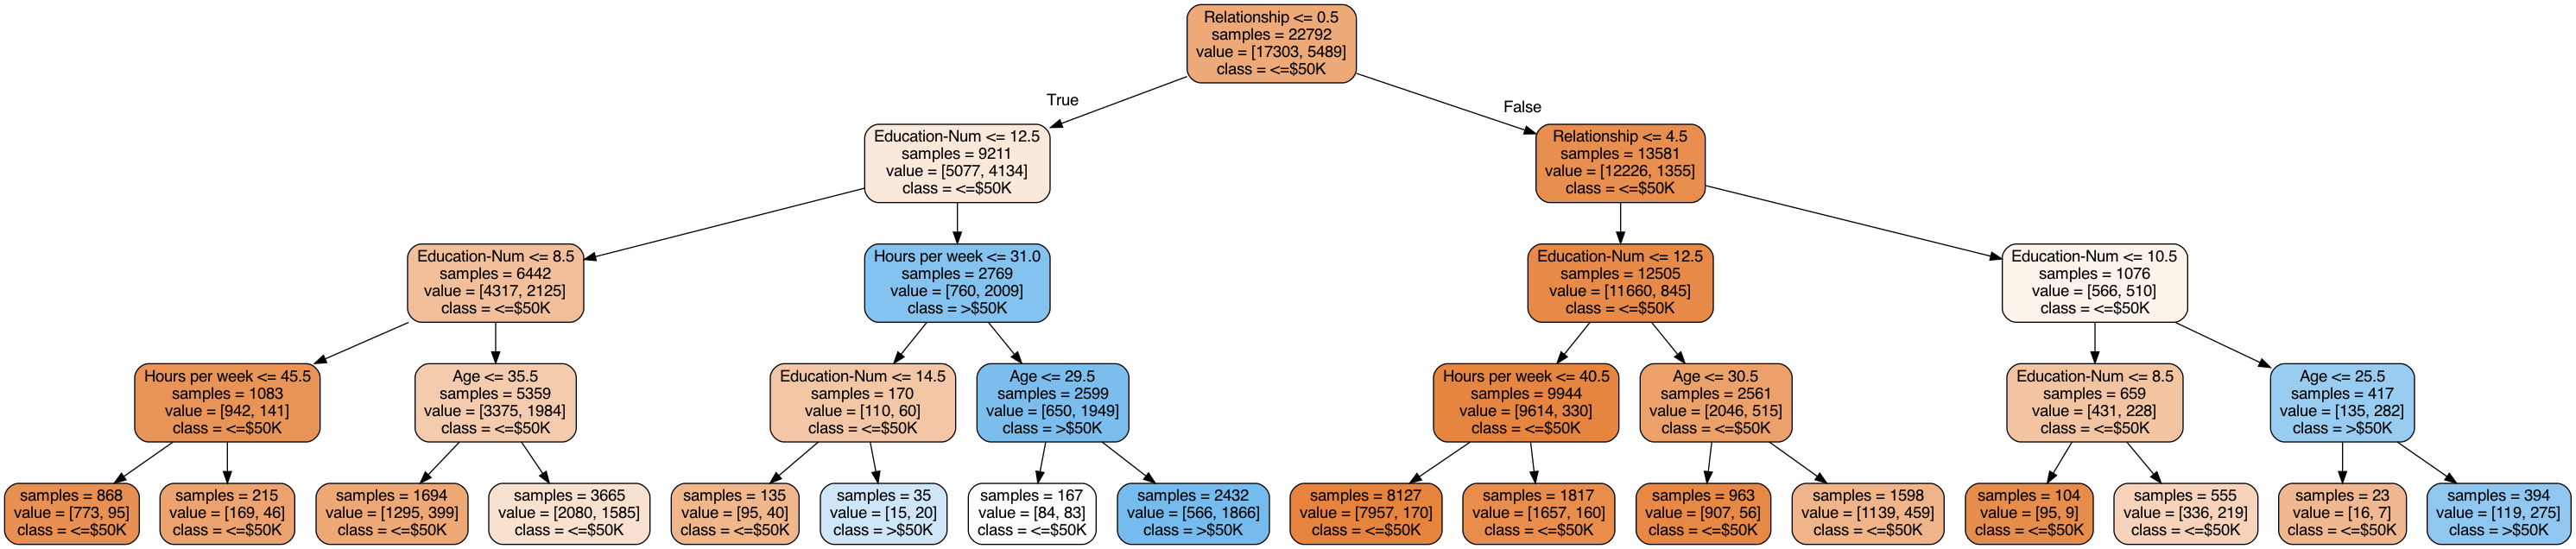

In [192]:
graph=pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

***
**Task 16**:  Explain the tree structure (including the meaning of the colors). 

Orange indicates level of confidence that that path will classify as class 0 (<=50k), and blue indicates confidence that classification will be class 1 (>50k).

When starting at the top of the tree, we see that without any decision, the model already somewhat predicts class 0.  Following the tree left, at the second layer, once we make the decision that education level is >12, we gain a bit of confidence that class might actually be 1, and so see a blue node appear.

We also see on the far right, that is relationship is >4.5 and education >10.5, we see a resurgence of class 1 confidence in more blue nodes.

The remainder of tree is orange, with dark orange (high confidence class 0 predictions) outweighing other predictions.

We also see a small number of pale boxes, which are borderline predictions.  However, even these are slightly orange, indicating that decisions will favour class 0.  There are only 3 nodes that result in a blue (class 1) classification.

# Explanation using LIME

Select any person from the dataset and get the LIME explanation for its classification.

In [193]:
# Change only the value of to select that person:
h = 50
###########

exp4 = explainer.explain_instance(X_test.iloc[h].values, tree.predict_proba, 
                                  distance_metric='euclidean', 
                                  num_features=len(X_test.iloc[h].values))
proba1 = tree.predict_proba(X_test.values)[h]

print("********************")
print('Test id: ' , h)
print('Probability(',exp4.class_names[0],") =", exp4.predict_proba[0])
print('Probability(',exp4.class_names[1],") =", exp4.predict_proba[1])
print('Predicted Label:', predictions[h])
print('True class: ' , y_test[h])
print("********************")


Intercept 0.01602987857549898
Prediction_local [0.55956602]
Right: 0.7672697368421053
********************
Test id:  50
Probability( <= $50K ) = 0.23273026315789475
Probability( > $50K ) = 0.7672697368421053
Predicted Label: 1
True class:  0
********************


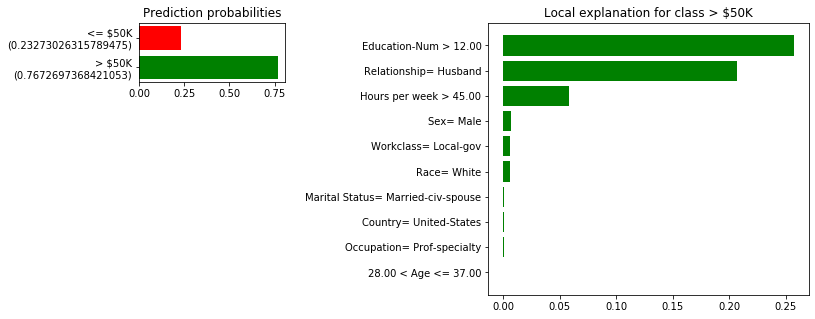

<Figure size 432x288 with 0 Axes>

In [194]:
plot_explanation(exp4, mapping)


***
**Task 17**:  Please provide comments on the above explanation provided by LIME using on the Tree structure above as a context to your explanation.

Person 50, through high amount of luck, has been incorrectly classified as class 1.  We can see by LIME that the 3 key features for this decision are education, relationship and hours per week.

If we look at the tree, we can see this element follows the blue left path of the tree.  Having an education over 12 years, a relationship and working over 45 hours perfectly follow the path to the bottom blue node area of the tree.  Age makes the final confirmation that this person is classified as class 1.

Had any of those features not been those values, we would likely have ended up down an orange branch (class 0).


# Your own test example

**Task 18**: Following the tree above, create your own test example that will be classified as income > $\$50$K by the decision tree. Explain how you select the values for the features. Use LIME to provide explanation to that test example.

Intercept 0.2353789859742968
Prediction_local [0.37089906]
Right: 0.6979695431472082
********************
Test id: Fake Person
Probability( <= $50K ) = 0.3020304568527919
Probability( > $50K ) = 0.6979695431472082


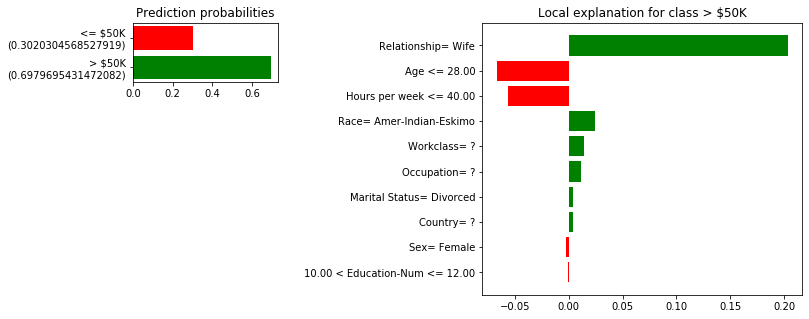

<Figure size 432x288 with 0 Axes>

In [195]:
#Create fake person to reach far right hand side of tree.
#We don't want to cheat and follow person 50 to the left.

#Examine Array shape/elements
# age, workclass, education, marital status, occupation, relationship, race, sex, hoursperweek, country

#First branch
#Relationship > 0.5

#Second Branch
#Relationship > 4.5

#Third branch
#Education > 10.5

#Fourth branch
#Age > 25.5

#So these are the only values we need to adjust.  Relationship, education, age
#The rest can be any value, it's irrelevant to our tree

fake_person = np.array([26,0,11,0,0,5,0,0,0,0])

exp5 = explainer.explain_instance(fake_person, tree.predict_proba, 
                                  distance_metric='euclidean', 
                                  num_features=len(fake_person))


print("********************")
print('Test id: Fake Person')
print('Probability(',exp5.class_names[0],") =", exp5.predict_proba[0])
print('Probability(',exp5.class_names[1],") =", exp5.predict_proba[1])

plot_explanation(exp5, mapping)

Following the tree, we know that we only had to fool 3 layers in the tree to reach a class 1 node on the far right.  To keep moving right, we knew that we had to pass (well, in this case fail) a few checks : Relationship needed to be > 0.5, although then in the next node relationship needed to be > 4.5.  Then, Education needed to be > 10.5, and finally Age >25.5.

Our fake person met all these traits, but nothing else.  For the decision tree, those other features we not relevant at all.
As for Lime, we see the most significant feature is relationship, which we know moved us through the two most significant nodes.  Interestingly, our Age (26), which cemented our class 1 decision at the bottom right of the tree is actually correlated more to a class 0 result.  However, we only had to defeat one node, and we knew the value that it needed.  Other values of Age = 26 compared elsewhere in the tree are likely not to have resulted in a class 1 classification.

Hours per week, our consistently relevant feature from other areas within this assignment did not have any impact on the final result; however, it is still represented in the Lime chart as being somewhat relevant.  Just not in our fake case.


# Congratulations!

You've come to the end of this assignment, and have seen a lot of the ways to explain the predictions given by a classifier.

Congratulations on finishing this notebook! 

